In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    f1_score,
    fbeta_score,
    make_scorer,
    recall_score,
    precision_score
)
from sklearn.feature_selection import (
    mutual_info_classif,
    SelectKBest,
)

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection as cv
import sklearn.neighbors as nb
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.precision", 3)

sns.set_style("dark")

In [3]:
results = pd.DataFrame()

def save_results(model_name, model, X, y, df):
    y_pred = model.predict(X)
    df.loc[model_name,'acc'] = accuracy_score(y, y_pred)
    df.loc[model_name,'precision score (W)'] = precision_score(y, y_pred, average='weighted')
    df.loc[model_name,'recall score (W)'] = recall_score(y, y_pred, average='weighted')
    df.loc[model_name,'f1 score (W)'] = f1_score(y, y_pred, average='weighted')
    return df

In [4]:
df = pd.read_csv("american_bankruptcy.csv")

dict = {
    "company_name": "Company name",
    "status_label": "Status",
    "year": "Year",
    "X1": "Current assets",
    "X2": "Cost goods sold",
    "X3": "DEP and AMO",
    "X4": "EBITDA",
    "X5": "Inventory",
    "X6": "Net income",
    "X7": "Total Receivables",
    "X8": "Market value",
    "X9": "Net sales",
    "X10": "Total assets",
    "X11": "Long-term debt",
    "X12": "EBIT",
    "X13": "Gross Profit",
    "X14": "Current Liabilities ",
    "X15": "Retained Earnings",
    "X16": "Total Revenue",
    "X17": "Total Liabilities",
    "X18": "Operating Expenses",
}

df = df.rename(columns=dict) #.sample(1000)

# Passem la variable objectiu a numerica (0 alive, 1 failed)
df['Status'] = df['Status'].map({'alive': 0, 'failed': 1})


df.head()

,Company name,Status,Year,Current assets,Cost goods sold,DEP and AMO,EBITDA,Inventory,Net income,Total Receivables,Market value,Net sales,Total assets,Long-term debt,EBIT,Gross Profit,Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Operating Expenses
0,C_1,0,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.752,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,0,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,377.118,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,0,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,364.593,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,0,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,143.329,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,0,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,308.907,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [5]:
df.describe()

,Status,Year,Current assets,Cost goods sold,DEP and AMO,EBITDA,Inventory,Net income,Total Receivables,Market value,Net sales,Total assets,Long-term debt,EBIT,Gross Profit,Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Operating Expenses
count,78682.000,78682.000,78682.000,78682.000,78682.000,78682.000,78682.000,78682.000,78682.000,7.868e+04,78682.000,78682.000,78682.000,78682.000,78682.000,78682.000,78682.000,78682.000,78682.000,78682.000
mean,0.066,2007.506,880.362,1594.529,121.234,376.759,201.606,129.382,286.833,3.414e+03,2364.020,2867.111,722.484,255.525,769.491,610.072,532.467,2364.020,1773.564,1987.260
std,0.249,5.743,3928.565,8930.485,652.377,2012.023,1060.766,1265.532,1335.979,1.841e+04,11950.069,12917.944,3242.171,1494.644,3774.703,2938.387,6369.159,11950.069,8053.685,10419.629
min,0.000,1999.000,-7.760,-366.645,0.000,-21913.000,0.000,-98696.000,-0.006,1.000e-04,-1964.999,0.001,-0.023,-25913.000,-21536.000,0.001,-102362.000,-1964.999,0.001,-317.197
25%,0.000,2002.000,18.924,17.038,1.192,-0.811,0.000,-7.416,3.281,3.498e+01,27.548,37.364,0.000,-2.787,8.521,8.889,-68.283,27.548,13.486,32.873
50%,0.000,2007.000,100.450,103.661,7.929,15.035,7.023,1.616,22.820,2.275e+02,186.599,213.203,7.594,6.518,63.581,43.333,-1.131,186.599,81.988,168.912
75%,0.000,2012.000,431.527,634.548,47.972,139.655,74.747,40.144,131.581,1.245e+03,1046.402,1171.365,248.761,87.599,344.074,222.817,146.070,1046.402,629.975,875.522
max,1.000,2018.000,169662.000,374623.000,28430.000,81730.000,62567.000,104821.000,65812.000,1.073e+06,511729.000,531864.000,166250.000,71230.000,137106.000,116866.000,402089.000,511729.000,337980.000,481580.000


In [6]:
df.isna().sum()

Company name            0
Status                  0
Year                    0
Current assets          0
Cost goods sold         0
DEP and AMO             0
EBITDA                  0
Inventory               0
Net income              0
Total Receivables       0
Market value            0
Net sales               0
Total assets            0
Long-term debt          0
EBIT                    0
Gross Profit            0
Current Liabilities     0
Retained Earnings       0
Total Revenue           0
Total Liabilities       0
Operating Expenses      0
dtype: int64

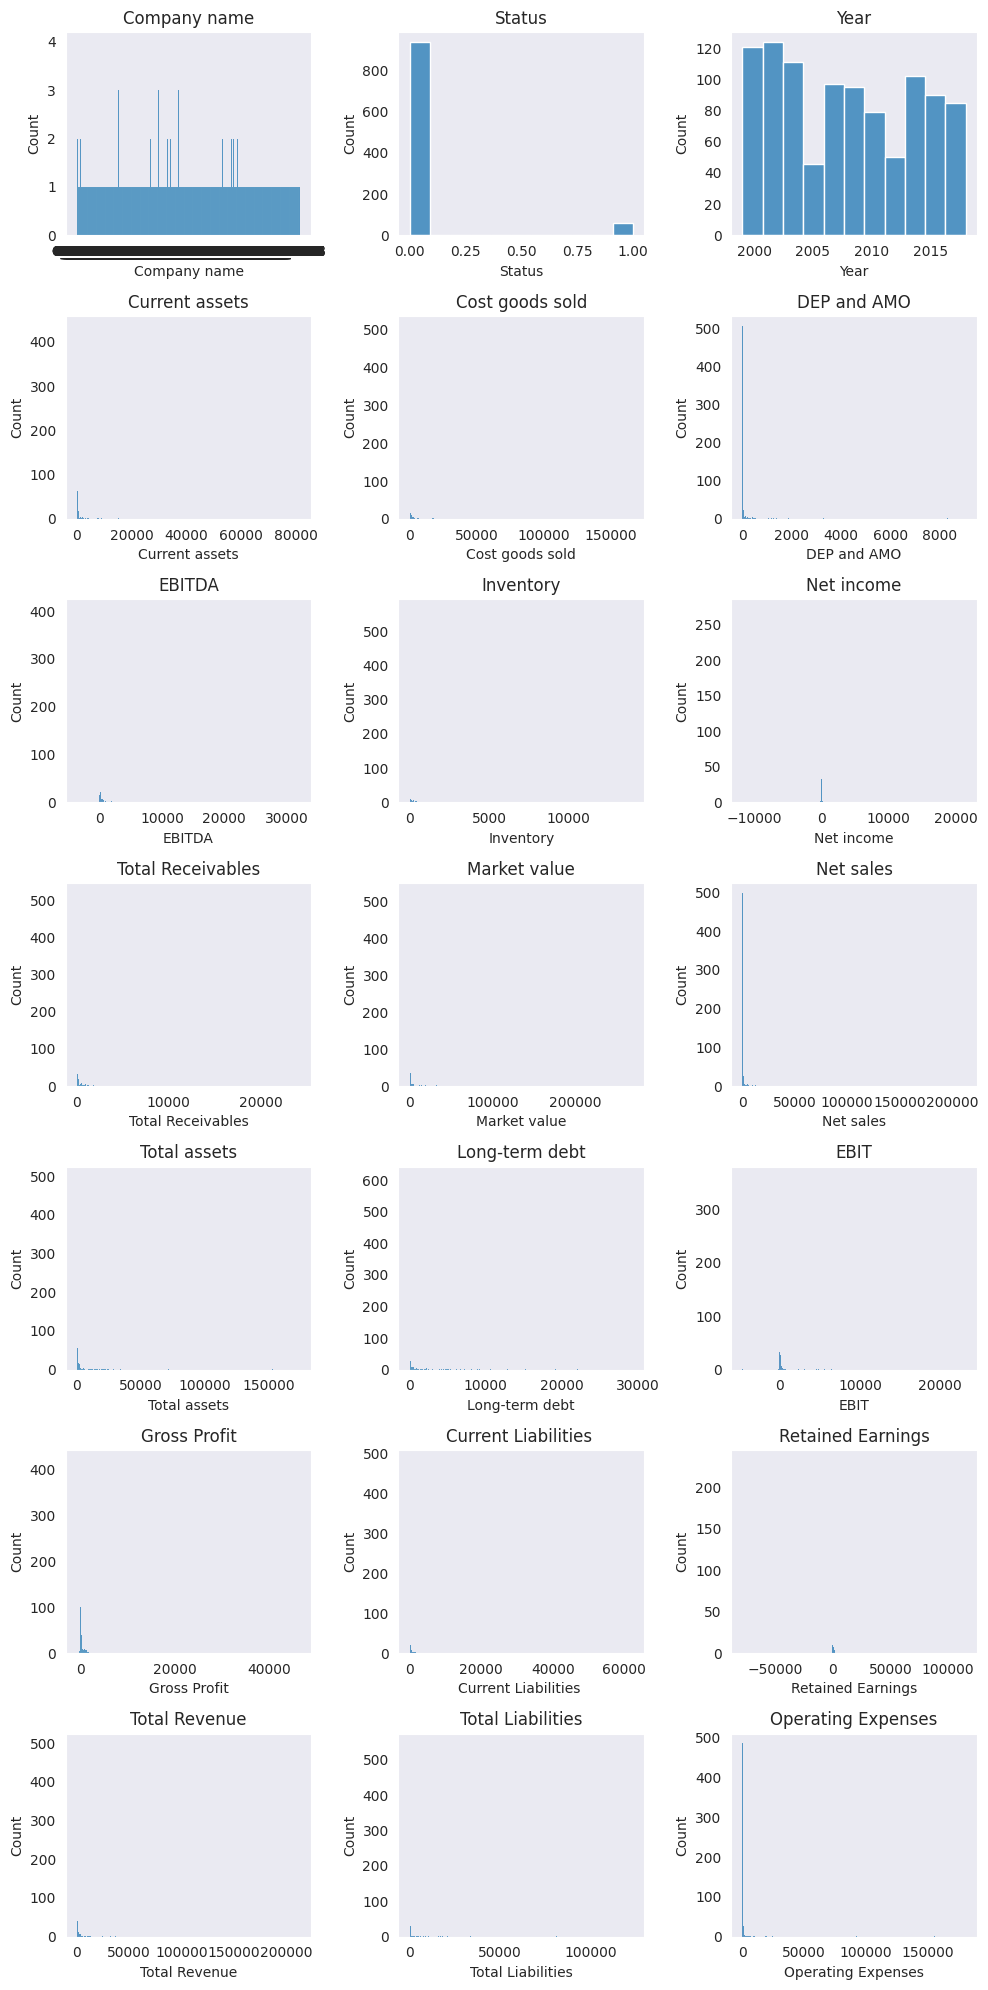

In [7]:
df2 = df.sample(1000)

fig, axes = plt.subplots(7,3,figsize=(10,20))

for i, c in enumerate(df2.columns):
    ax = axes.reshape(-1)[i]
    if df2[c].dtype.kind == "object":
        a = sns.countplot(x=c,data=df2,ax=ax)
    else:
        b = sns.histplot(x=c,data=df2,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

array([[<Axes: xlabel='Status', ylabel='Status'>,
        <Axes: xlabel='Year', ylabel='Status'>,
        <Axes: xlabel='Current assets', ylabel='Status'>,
        <Axes: xlabel='Cost goods sold', ylabel='Status'>,
        <Axes: xlabel='DEP and AMO', ylabel='Status'>,
        <Axes: xlabel='EBITDA', ylabel='Status'>,
        <Axes: xlabel='Inventory', ylabel='Status'>,
        <Axes: xlabel='Net income', ylabel='Status'>,
        <Axes: xlabel='Total Receivables', ylabel='Status'>,
        <Axes: xlabel='Market value', ylabel='Status'>,
        <Axes: xlabel='Net sales', ylabel='Status'>,
        <Axes: xlabel='Total assets', ylabel='Status'>,
        <Axes: xlabel='Long-term debt', ylabel='Status'>,
        <Axes: xlabel='EBIT', ylabel='Status'>,
        <Axes: xlabel='Gross Profit', ylabel='Status'>,
        <Axes: xlabel='Current Liabilities ', ylabel='Status'>,
        <Axes: xlabel='Retained Earnings', ylabel='Status'>,
        <Axes: xlabel='Total Revenue', ylabel='Status'>,
   

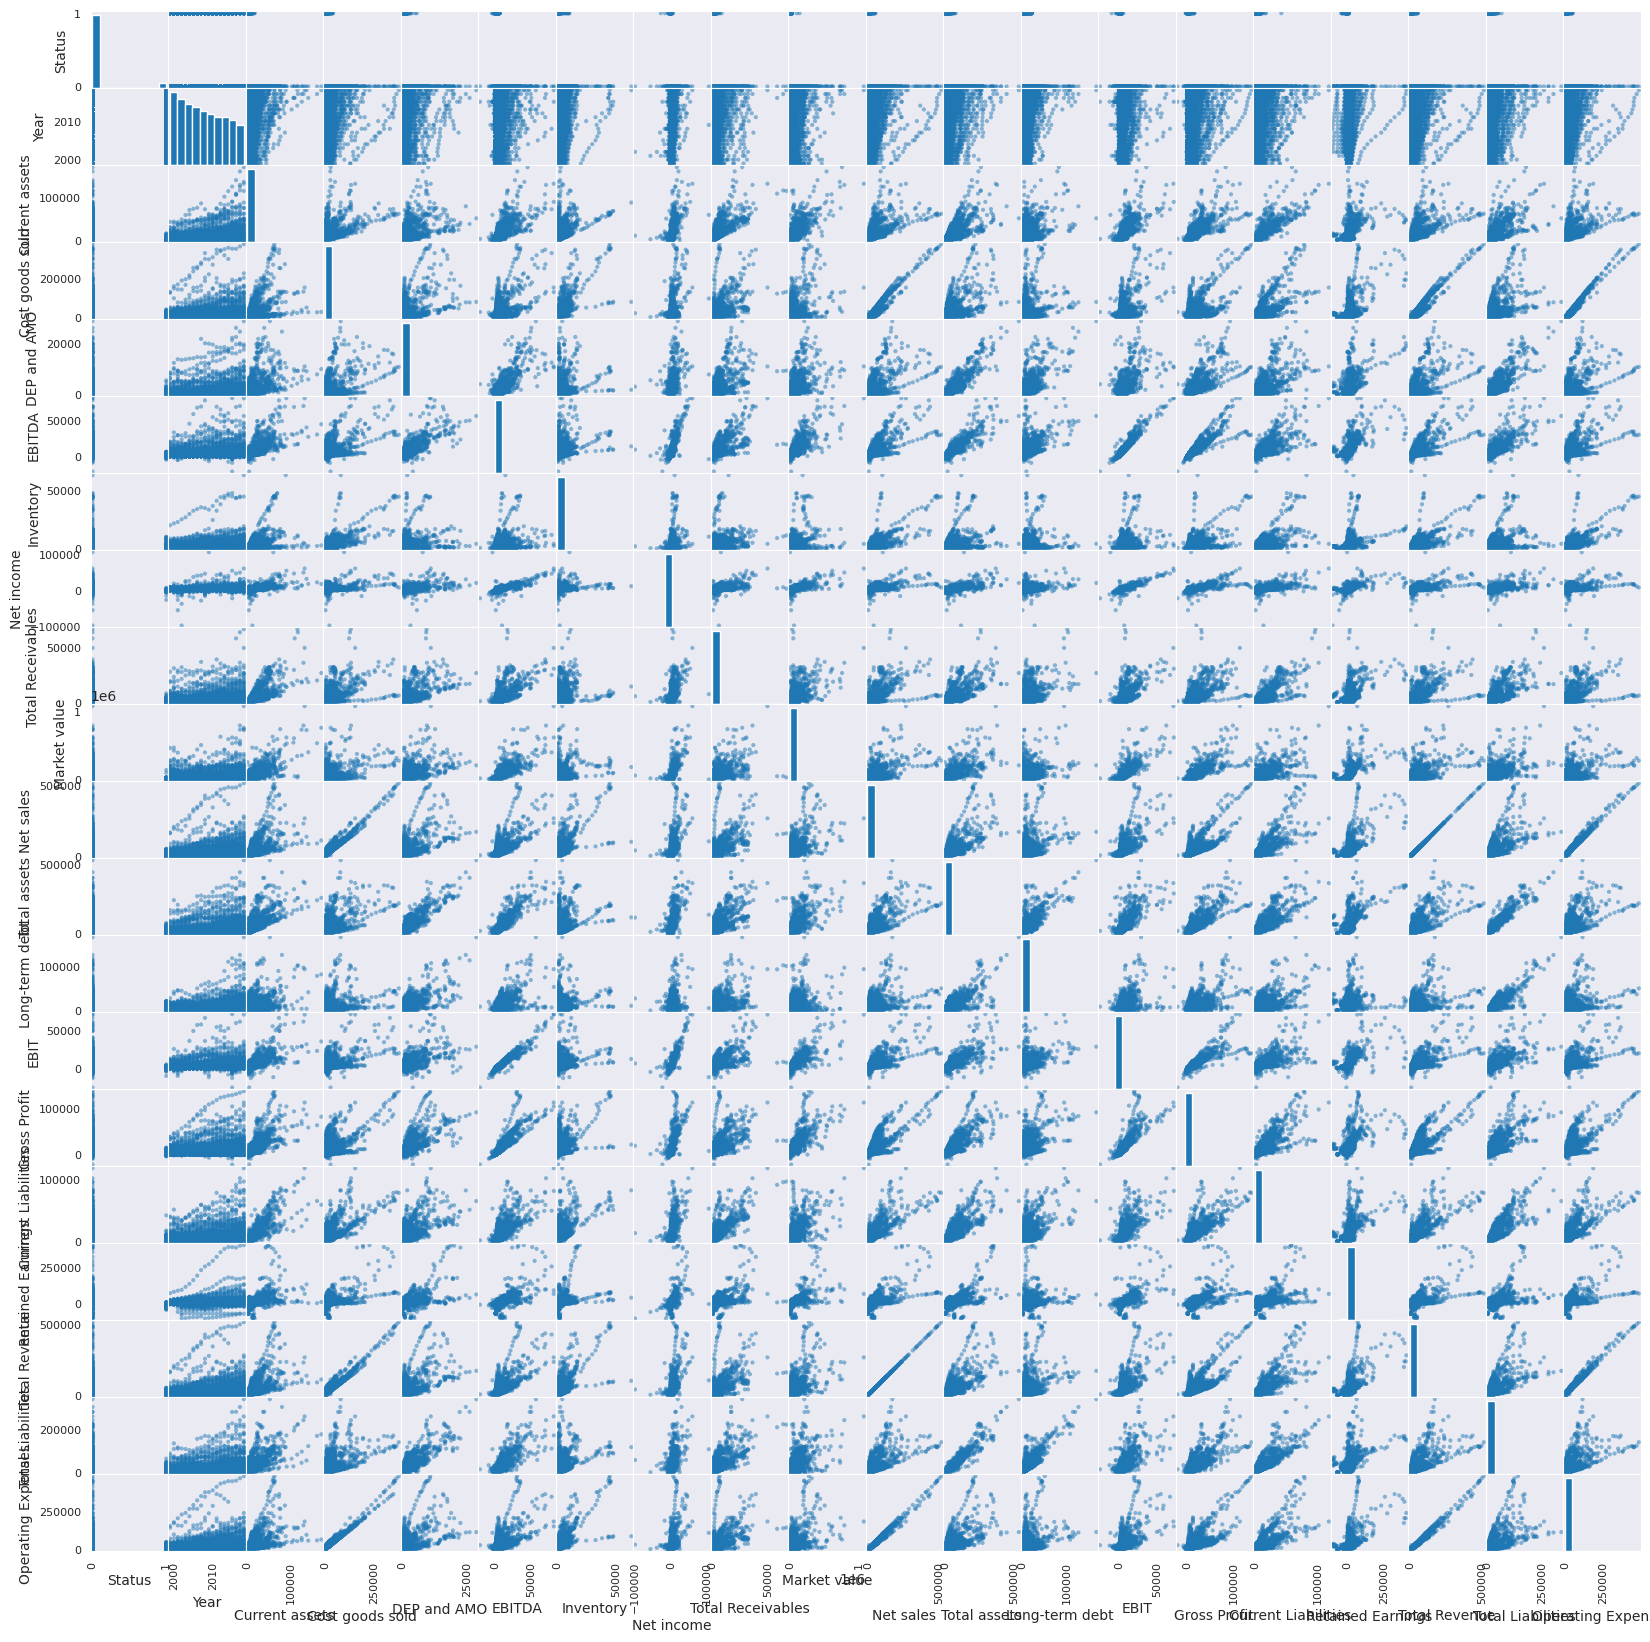

In [8]:
pd.plotting.scatter_matrix(df, figsize=(20,20))

### Correlation matrix

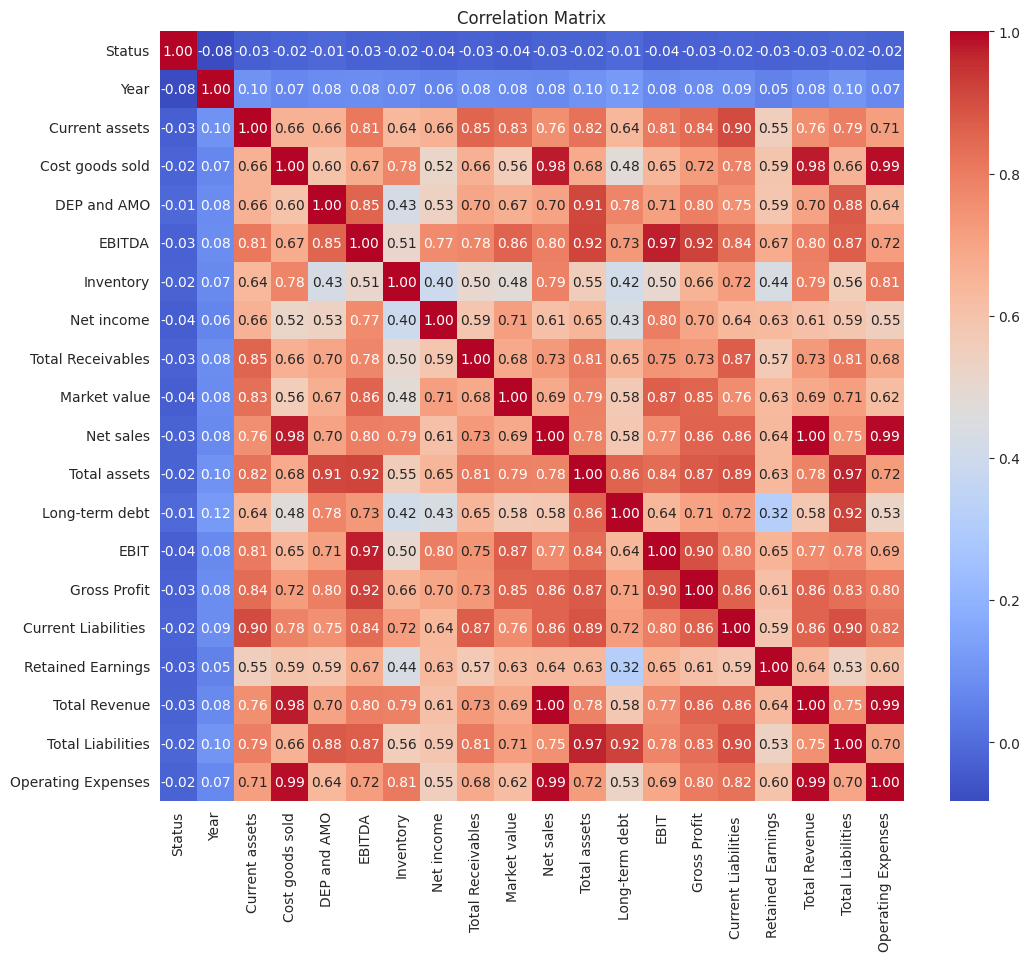

In [9]:
non_numeric_columns = df.select_dtypes(exclude='number').columns
df_numeric_columns = df.drop(columns=non_numeric_columns)
correlation_matrix = df_numeric_columns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Dataset transformation
Currently, the dataset contains multiple entries for the same company. Every one of these rows is from a different year. Since we are trying to predict a company's outcome based on their financial history, we are going to transform the dataset so that one row has all the information about one company, using information from the 3 latest years.

In [10]:
df["Company name"].value_counts().value_counts().sort_index()

# drop de companies with less than 4 entries
df = df[df["Company name"].map(df["Company name"].value_counts()) >= 3]

df["Company name"].value_counts().value_counts().sort_index()


count
3      756
4      681
5      616
6      573
7      497
8      427
9      402
10     265
11     290
12     295
13     240
14     194
15     186
16     168
17     148
18     158
19     242
20    1172
Name: count, dtype: int64

## Quedarnos amb els tres ultims anys de cada empresa i triplicar les columnes una per cada any
    El Year de l'empresa es el menys recent dels tres

In [11]:
# Ordenar per empresa i any i agafar els 3 anys més recents de cada empresa
df = df.sort_values(["Company name", "Year"])
df = df.groupby("Company name").tail(3)

# Llista per les noves files
noves_files = []

# Agrupar el dataframe por cada 3 filas (cada empresa)
num_ocurrencies_per_empresa = 3
num_columnes_original = len(df.columns)
num_columnas_nuevo = num_columnes_original * num_ocurrencies_per_empresa

# Guardo en noves_files una llista on cada element es una fila dels 3 anys d'una empresa
for i in range(0, len(df), num_ocurrencies_per_empresa):
    grup = df.iloc[i:i + num_ocurrencies_per_empresa]
    fila_nova = []

    for _, fila in grup.iterrows():
        fila_nova.extend(fila)

    noves_files.append(fila_nova)

# Crear les columnes noves
noves_columnes = []
for j in range(num_ocurrencies_per_empresa):
    for col in df.columns:
        noves_columnes.append(f'{col}_{j+1}')

# Crear el nou dataframe
df_preprocessat = pd.DataFrame(noves_files, columns=noves_columnes)

# Eliminar les columnes que no volem
df_preprocessat = df_preprocessat.drop(columns=['Year_2', 'Year_3', 'Status_2', 'Status_3', 'Company name_2', 'Company name_3'])

# Ordenar per any per tenir algun criteri de visualització
df_preprocessat = df_preprocessat.sort_values('Year_1')

In [12]:
columns = list(df_preprocessat.columns[2:])

### Balancing

In [13]:
X = df_preprocessat.values[:,2:]
y = df_preprocessat.values[:,1]

y = y.astype(int)

In [14]:
# Let's separate data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Proportion of examples in the smaller class (class 1) is the following
percent_smaller_class = 100 * np.sum(y == 1)/(np.sum(y == 0) + np.sum(y == 1))

print(f"Percentage of examples of the smaller class (class 1): {percent_smaller_class:.2f}%")

Percentage of examples of the smaller class (class 1): 7.89%


In [15]:
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

r_scorer = make_scorer(recall_score,pos_label=1)

# print(len(X[0]))

clf = nb.KNeighborsClassifier(n_neighbors = 2).fit(X_resampled, y_resampled)
y_pred_bal = clf.predict(X_test)
print(classification_report(y_test, y_pred_bal))
print("Confusion matrix on test set:\n",confusion_matrix(y_test, y_pred_bal))

scores = cross_val_score(clf, X_resampled, y_resampled, cv=5, scoring=r_scorer)

print("Scores de validación cruzada:", scores)
print("Promedio de scores:", scores.mean())

              precision    recall  f1-score   support

           0       1.00      0.79      0.88      2019
           1       0.29      0.99      0.45       174

    accuracy                           0.81      2193
   macro avg       0.65      0.89      0.67      2193
weighted avg       0.94      0.81      0.85      2193

Confusion matrix on test set:
 [[1600  419]
 [   1  173]]
Scores de validación cruzada: [0.99848714 0.99924357 0.99848714 0.99772899 0.99848714]
Promedio de scores: 0.9984867971245366


### Data Scaling

In [16]:
# One way is to standarize all data mean 0, std 1
scaler = StandardScaler().fit(X_resampled)
X2_scaled = scaler.transform(X_resampled)

for i in range(55):
    print('std:',X2_scaled[:,i].std(),'min',X2_scaled[:,i].min(),'max',X2_scaled[:,i].max())

std: 1.0000000000000049 min -1.8674241442971138 max 1.4085930354973193
std: 1.0000000000000009 min -0.18052695588841772 max 40.123176758472745
std: 1.0000000000000004 min -0.16869332714080829 max 54.98177946324106
std: 1.0000000000000018 min -0.18030245168809103 max 45.56059384212727
std: 1.0000000000000022 min -2.9981342015484764 max 47.61311077277061
std: 0.999999999999985 min -0.16377175296012994 max 52.19208514231789
std: 1.0000000000000002 min -7.589553902530541 max 56.17224617800239
std: 1.0000000000000004 min -0.17340491725328672 max 51.17855440880437
std: 1.0000000000000013 min -0.14697035929038685 max 41.26837549631108
std: 1.000000000000001 min -0.21132696863267766 max 55.64424150793441
std: 1.000000000000002 min -0.20023036827163251 max 36.331515147694304
std: 1.0000000000000127 min -0.22610328535852015 max 34.257972290238
std: 0.9999999999999986 min -5.933137821997588 max 56.241524525911444
std: 1.0000000000000089 min -1.536209073670579 max 45.48252658397392
std: 1.00000000

In [17]:
X_resampled_df = pd.DataFrame(X_resampled, columns=columns)

print(X_resampled_df)

         Year_1  Current assets_1  Cost goods sold_1  DEP and AMO_1  EBITDA_1  Inventory_1  Net income_1  Total Receivables_1  Market value_1  Net sales_1  Total assets_1  Long-term debt_1   EBIT_1  Gross Profit_1  Current Liabilities _1  Retained Earnings_1  Total Revenue_1  Total Liabilities_1  Operating Expenses_1  Current assets_2  Cost goods sold_2  DEP and AMO_2  EBITDA_2  Inventory_2  Net income_2  Total Receivables_2  Market value_2  Net sales_2  Total assets_2  Long-term debt_2   EBIT_2  Gross Profit_2  Current Liabilities _2  Retained Earnings_2  Total Revenue_2  Total Liabilities_2  Operating Expenses_2  Current assets_3  Cost goods sold_3  DEP and AMO_3  EBITDA_3  Inventory_3  Net income_3  Total Receivables_3  Market value_3  Net sales_3  Total assets_3  Long-term debt_3  EBIT_3  Gross Profit_3  Current Liabilities _3  Retained Earnings_3  Total Revenue_3  Total Liabilities_3  Operating Expenses_3
0      1999.000            95.706            330.029         11.650    43.74

### Ranking

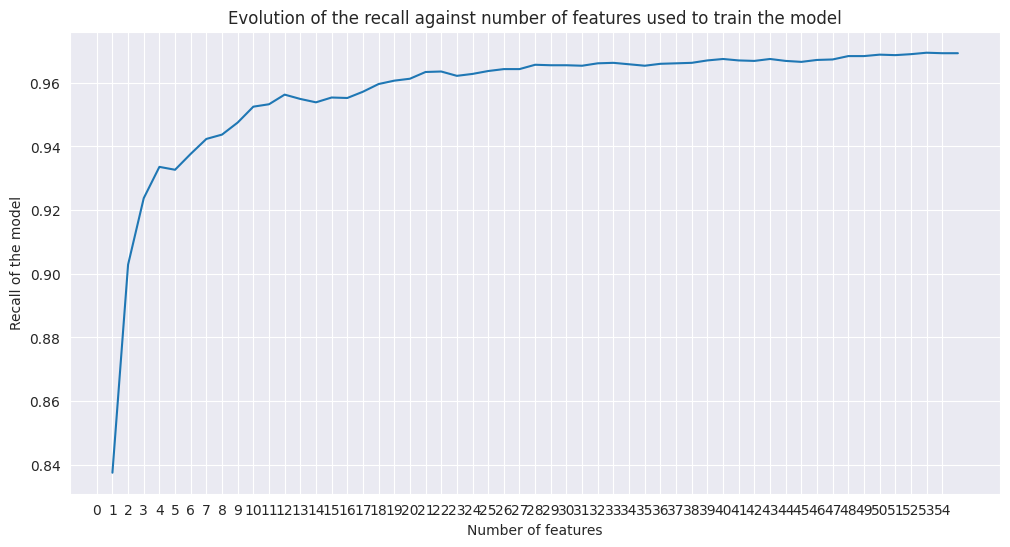

In [18]:
# print(len(X2_scaled))

original = np.zeros(55)

recall = make_scorer(recall_score, pos_label=1)

X_bank_df = pd.DataFrame(X, columns=df_preprocessat.columns[2:])

kbestfeatures = []

for i in range(55):
    selector = SelectKBest(mutual_info_classif, k=i+1)
    X_reduced = selector.fit_transform(X2_scaled, y_resampled)
    cols_idxs = selector.get_support(indices=True)
    nombres = [X_bank_df.columns[j] for j in cols_idxs]
    kbestfeatures.append(nombres)
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_scores = cross_val_score(nb.KNeighborsClassifier(), X=X_reduced,y=y_resampled, cv=cv, scoring=recall)
    original[i]=np.mean(cv_scores)

fig = plt.figure(figsize = (12, 6))  # Just declare the figure object and give dimensions
plt.grid(True)
plt.title("Evolution of the recall against number of features used to train the model")
plt.ylabel("Recall of the model")
plt.xlabel("Number of features")
plt.xticks(np.arange(0, 55, step=1))
plt.plot(range(1,56), original)
plt.show()

In [19]:
bestFeatures = kbestfeatures[12]

### SPLIT INTO 70 % TRAIN AND 30 % TEST

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state = 42, test_size = 0.3)

### MODELS:

### KNN

We don't scale the target variable because when doing KNN, we compute the distance between variables and the target variable is not used in the distance computation

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
cv = StratifiedKFold(n_splits = 10)

cv_scores = cross_val_score(
    nb.KNeighborsClassifier(),
    X = X_train_scaled,
    y = y_train,
    cv = cv,
    scoring = "recall"
)
print(f"Mean scores: {np.mean(cv_scores)}")

Mean scores: 0.962214223083668


In [23]:
indices = [df_preprocessat.columns.get_loc(col) - 2 for col in bestFeatures]

cv_scores = cross_val_score(
    nb.KNeighborsClassifier(),
    X = X_train_scaled[:, indices],
    y = y_train,
    cv = cv,
    scoring = "recall"
)
print(f"Mean scores: {np.mean(cv_scores)}")

Mean scores: 0.9446130416724353


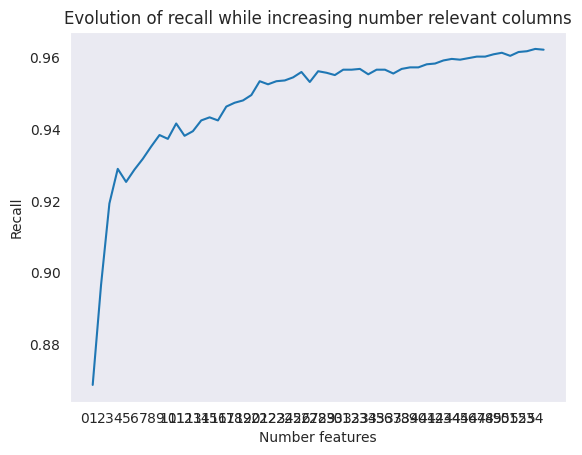

In [24]:
vector_of_means = np.zeros(55)
for i in range(55):
    X_new = SelectKBest(
        mutual_info_classif, k = i + 1
    ).fit_transform(X_train_scaled, y_train)
    cv_scores = cross_val_score(
        nb.KNeighborsClassifier(),
        X = X_new,
        y = y_train,
        cv = cv,
        scoring = "recall"
    )
    vector_of_means[i] = np.mean(cv_scores)

plt.title("Evolution of recall while increasing number relevant columns")
plt.xlabel("Number features")
plt.ylabel("Recall")
plt.xticks(np.arange(0, 55, step = 1))
plt.plot(
    range(1,56),
    vector_of_means
)
plt.show()

As we can see in the plot, using the maximum amount of features the results are better, so we will take all the features

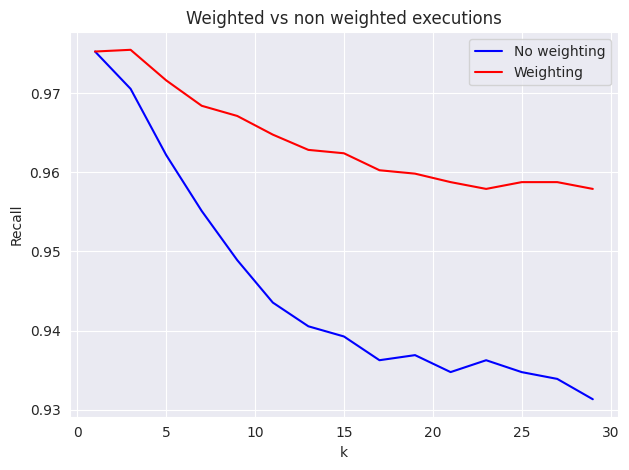

In [25]:
no_weighted_means = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(
        nb.KNeighborsClassifier(n_neighbors = ki),
        X = X_train_scaled,
        y = y_train,
        cv = 10,
        scoring='recall'
    )
    no_weighted_means.append(np.mean(cv_scores))

plt.plot(
    range(1,30,2),
    no_weighted_means,
    "b",
    label = "No weighting"
)

weighted_means = []
for ki in range(1,30,2):
    cv_scores = cross_val_score(
        nb.KNeighborsClassifier(
            n_neighbors = ki,
            weights = "distance"
        ),
        X = X_train_scaled,
        y = y_train,
        cv = 10,
        scoring='recall'
    )
    weighted_means.append(np.mean(cv_scores))

plt.plot(
    range(1,30,2),
    weighted_means,
    "r",
    label = "Weighting"
)

plt.title("Weighted vs non weighted executions")
plt.xlabel("k")
plt.ylabel("Recall")
plt.legend(loc = "upper right")
plt.grid()
plt.tight_layout()
plt.show()

In [26]:
cv = StratifiedKFold(n_splits = 10)

params = {
    "n_neighbors": list(range(1,30,2)),
    "weights": ("distance", "uniform")
}
knc = nb.KNeighborsClassifier()
clfKNN = GridSearchCV(
    knc,
    param_grid = params,
    cv = cv,
    n_jobs = -1,
    scoring='recall'
)
clfKNN.fit(X_train_scaled, y_train)


print(f"Best Params = {clfKNN.best_params_}\nRecall = {clfKNN.best_score_}")

Best Params = {'n_neighbors': 3, 'weights': 'distance'}
Recall = 0.9755258664451519


### What about PCA for dimensionality reduction?

In [27]:
pca = PCA(n_components = 2)
pca.fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)

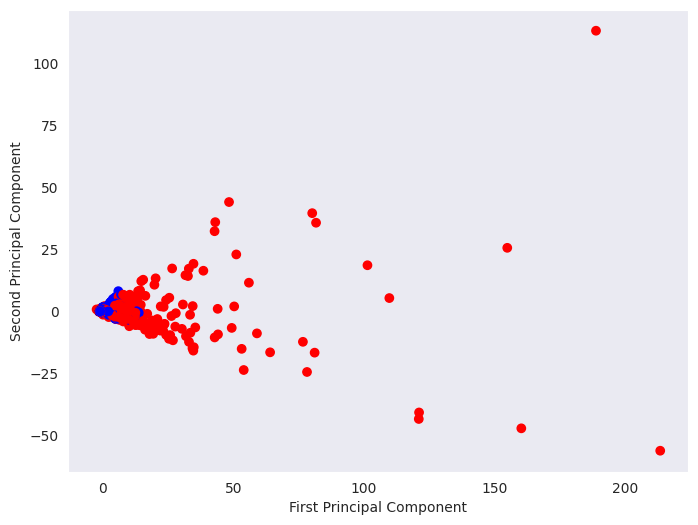

In [28]:
colors = ['red', 'blue']
colors_map = [colors[tag] for tag in y_train]

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors_map)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [29]:
params = {
    "n_neighbors": list(range(1,30,2)),
    "weights": ("distance", "uniform")
}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(
    knc,
    param_grid = params,
    cv = cv,
    n_jobs = -1,
    scoring='recall'
)
clf.fit(X_pca, y_train)

print(f"Best Params = {clf.best_params_}\nRecall = {clf.best_score_}")

Best Params = {'n_neighbors': 29, 'weights': 'distance'}
Recall = 0.8537929761410309


In [30]:
# Not very good because does not consider labels in the reduction. Let's try LDA that is similar to PCA
# but takes into account labels
lda = LinearDiscriminantAnalysis(n_components = 1)
X_lda = lda.fit(X_train_scaled, y_train).transform(X_train_scaled)

params = {
    "n_neighbors": list(range(1,30,2)),
    "weights": ("distance", "uniform")
}
knc = nb.KNeighborsClassifier()
clf = GridSearchCV(
    knc,
    param_grid = params,
    cv = cv,
    n_jobs = -1,
    scoring='recall'
)
clf.fit(X_lda, y_train)

print(f"Best Params = {clf.best_params_}\nRecall = {clf.best_score_}")

Best Params = {'n_neighbors': 27, 'weights': 'uniform'}
Recall = 0.9222871383081822


In [31]:
save_results("KNN", clfKNN, X_test, y_test, results)

,acc,precision score (W),recall score (W),f1 score (W)
KNN,0.417,0.174,0.417,0.246


### Naive Bayes Classifier

In [32]:
# We will use X_resampled and not X2_scaled because data without scaling works well with the Algorithm
X_naive_1 = X_resampled.copy()
y_naive_1 = y_resampled.copy()

In [33]:
from sklearn.naive_bayes import GaussianNB

# Configurar la validación cruzada estratificada
cv = StratifiedKFold(n_splits = 10)

# Crear el modelo Naive Bayes
gnb = GaussianNB()

# Realizar la validación cruzada y obtener las puntuaciones
cv_scores = cross_val_score(
    gnb,
    X = X_naive_1,
    y = y_naive_1,
    cv = cv,
    scoring = "recall"
)

# Calcular y mostrar la media de las puntuaciones
mean_cv_score = np.mean(cv_scores)
print(mean_cv_score)

0.945075184522991


In [34]:
from sklearn.model_selection import cross_val_predict  

predicted = cross_val_predict(
    estimator = GaussianNB(), 
    X = X_naive_1,
    y = y_naive_1,  
    cv = cv,
)  

print(confusion_matrix(y_naive_1, predicted))  # Confusion matrix
print(accuracy_score(y_naive_1, predicted))    # Accuracy compute using both, true value and prediction
print(classification_report(y_naive_1, predicted))

[[ 666 3888]
 [ 363 6246]]
0.6191883902176835
              precision    recall  f1-score   support

           0       0.65      0.15      0.24      4554
           1       0.62      0.95      0.75      6609

    accuracy                           0.62     11163
   macro avg       0.63      0.55      0.49     11163
weighted avg       0.63      0.62      0.54     11163



In [35]:
X_train_bayes = X_train.copy()
X_test_bayes = X_test.copy()
y_train_bayes = y_train.copy()
y_test_bayes = y_test.copy()

In [36]:
def filterp(th,ProbClass1):
    """Given a threshold "th" and a set of probabilities of belonging to class 1 "ProbClass1", 
    return predictions.""" 
    y = np.zeros(ProbClass1.shape[0])
    for i,v in enumerate(ProbClass1):
        if ProbClass1[i]>th:
            y[i]=1
    return y  

clf_bayes = GaussianNB()
lth=[]

# We do a 10-fold cross-validation with 10 iterations
kf = StratifiedKFold(
    n_splits = 20, 
    shuffle = True, 
    random_state = 42
)

# Now we compute the threshold by iterating the data we have
for train_index, test_index in kf.split(X_train, y_train):
    
    X_train2, X_test2 = X_naive_1[train_index], X_naive_1[test_index]
    y_train2, y_test2 = y_naive_1[train_index], y_naive_1[test_index]

    # Train with the training data of the iteration 
    clf_bayes.fit(X_train2, y_train2)
    # Obtaining probability predictions for test data of the iteration
    probs = clf_bayes.predict_proba(X_test2)
    # Collect probabilities of belonging to class 1
    ProbClass1 = probs[:,1]
    # Sort probabilities and generate pairs (threshold, f1-for-that-threshold) 
    res = np.array([[th,recall_score(y_test2,filterp(th,ProbClass1),pos_label=1)] for th in np.sort(ProbClass1)])
    
    """
    # Uncomment the following lines if you want to plot at each iteration how f1-score 
    # evolves increasing the threshold 
    plt.plot(res[:,0],res[:,1])
    plt.show()
    """
    
    # Find the threshold that has maximum value of f1-score
    maxF = np.max(res[:,1])
    pl = np.argmax(res[:,1])
    optimal_th = res[pl,0]
    
    # Store the optimal threshold found for the current iteration
    lth.append(optimal_th)

# Compute the average threshold for all 10 iterations    
threshold = np.mean(lth)
print(f"Selected threshold in 10-fold cross validation: {np.round(threshold, 6)}")

Selected threshold in 10-fold cross validation: 0.0


In [37]:
# Train a classifier with the whole training data 
clf_bayes_2 = GaussianNB()
clf_bayes_2.fit(X_train_bayes, y_train_bayes)

# Obtain probabilities for data on test set
probs = clf_bayes_2.predict_proba(X_test_bayes)

# Generate predictions using probabilities and threshold found on 10 folds cross-validation
prediction = filterp(threshold,probs[:,1])

# print results
print(classification_report(y_test_bayes, prediction))
print(confusion_matrix(y_test_bayes, prediction))  # Confusion matrix

              precision    recall  f1-score   support

           0       0.87      0.06      0.11      1398
           1       0.60      0.99      0.75      1951

    accuracy                           0.60      3349
   macro avg       0.73      0.53      0.43      3349
weighted avg       0.71      0.60      0.48      3349

[[  86 1312]
 [  13 1938]]


In [38]:
save_results("Naive Bayes Classifier", clf_bayes_2, X_test_bayes, y_test_bayes, results)

,acc,precision score (W),recall score (W),f1 score (W)
KNN,0.417,0.174,0.417,0.246
Naive Bayes Classifier,0.604,0.609,0.604,0.521


In [39]:
####### EXEMPLE DE COM GUARDAR ELS RESULTATS, POSEM NOM DEL MODEL, el objecte amb el que fem predict, X_test i y_test, i results

# save_results("KNN", clf, X_test, y_test, results)